# Taller
### Implementar un modelo de clasificación para predecir la enfermedad de las hojas de mango
### * Crear un vector de características HOG
### *  Usar el modelo de clasificación de su preferencia (Redes Neuronales, Árboles, KNN, SVM)
### *  Evaluar (Acc. - F1-Score)

In [1]:
#pip install -U scikit-image

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import pandas as pd
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

## PASO 1: ANÁLISIS DESCRIPTIVO DEL DATASET

In [3]:
dataset_path = 'mango_leaf_disease'

# Obtener todas las clases (carpetas)
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
classes.sort()

print("=== ANÁLISIS DESCRIPTIVO DEL DATASET ===")
print(f"Número de clases: {len(classes)}")
print(f"Clases disponibles: {classes}")
print()

=== ANÁLISIS DESCRIPTIVO DEL DATASET ===
Número de clases: 8
Clases disponibles: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']



In [4]:
# Analizar cada clase
class_info = []
total_images = 0

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    num_images = len(images)
    total_images += num_images
    
    # Obtener información de una imagen de muestra
    if images:
        sample_image_path = os.path.join(class_path, images[0])
        sample_img = imread(sample_image_path)
        height, width = sample_img.shape[:2]
        channels = sample_img.shape[2] if len(sample_img.shape) == 3 else 1
        
        class_info.append({
            'Clase': class_name,
            'Número de imágenes': num_images,
            'Altura (px)': height,
            'Ancho (px)': width,
            'Canales': channels
        })
    else:
        class_info.append({
            'Clase': class_name,
            'Número de imágenes': 0,
            'Altura (px)': 'N/A',
            'Ancho (px)': 'N/A',
            'Canales': 'N/A'
        })

df_info = pd.DataFrame(class_info)

print(f"TOTAL DE IMÁGENES EN EL DATASET: {total_images}")
df_info


TOTAL DE IMÁGENES EN EL DATASET: 4000


,Clase,Número de imágenes,Altura (px),Ancho (px),Canales
0,Anthracnose,500,240,240,3
1,Bacterial Canker,500,320,240,3
2,Cutting Weevil,500,240,240,3
3,Die Back,500,240,240,3
4,Gall Midge,500,320,240,3
5,Healthy,500,240,320,3
6,Powdery Mildew,500,320,240,3
7,Sooty Mould,500,240,320,3


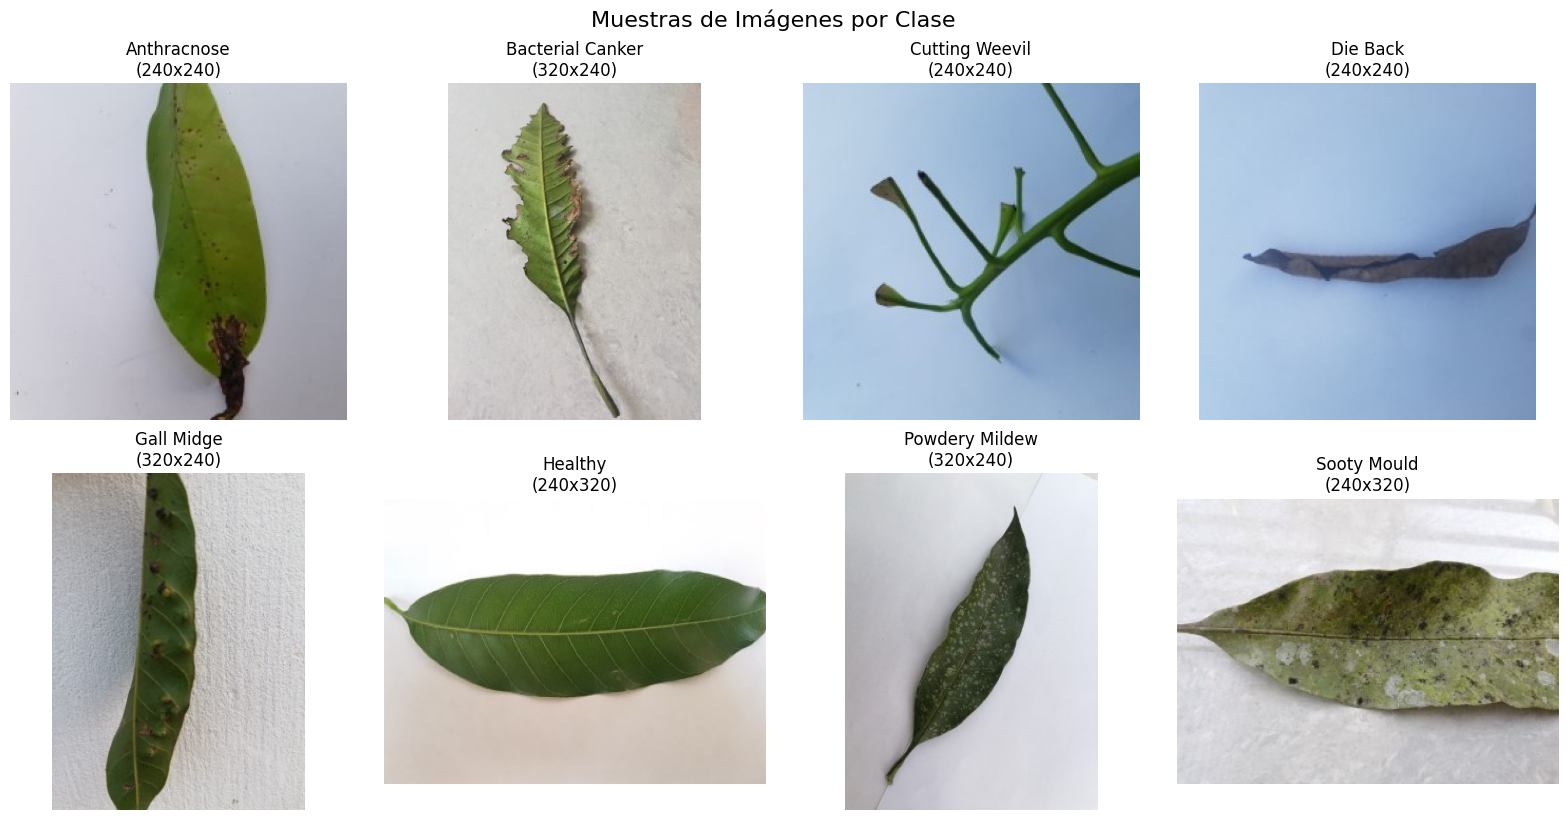

In [5]:
# PASO 2: VISUALIZACIÓN DE IMÁGENES DE MUESTRA


# Crear una visualización con una imagen de muestra de cada clase
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if images:
        # Tomar la primera imagen de cada clase
        sample_image_path = os.path.join(class_path, images[0])
        img = imread(sample_image_path)
        
        axes[i].imshow(img)
        axes[i].set_title(f'{class_name}\n({img.shape[0]}x{img.shape[1]})')
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, 'No hay imágenes', ha='center', va='center')
        axes[i].set_title(class_name)
        axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Muestras de Imágenes por Clase', y=1.02, fontsize=16)
plt.show()


## PASO 2: IMPLEMENTACIÓN DE HOG

Probando HOG con imagen de la clase: Anthracnose
Ruta de la imagen: mango_leaf_disease/Anthracnose/20211011_171136 - Copy - Copy - Copy (Custom).jpg
Dimensiones originales: (240, 240, 3)
Dimensiones redimensionadas: (240, 240, 3)


/var/folders/0z/3s22b27525jc3bm0m923h36h3wg489/T/ipykernel_86366/3057243361.py:17: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(img)
/var/folders/0z/3s22b27525jc3bm0m923h36h3wg489/T/ipykernel_86366/3057243361.py:26: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(resized_img)


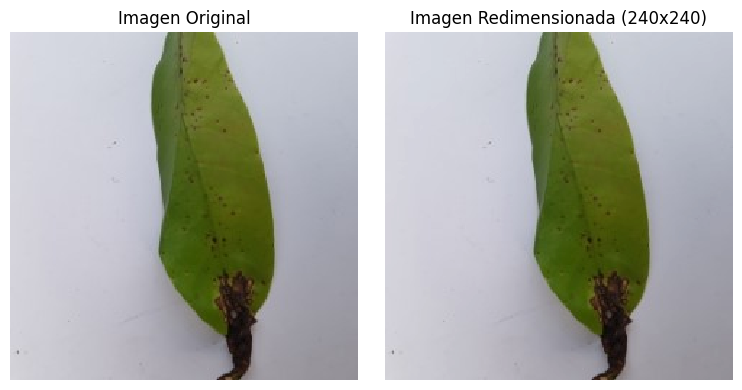

In [6]:
# Tomar una imagen de muestra para probar HOG
sample_class = classes[0]  # Primera clase
sample_path = os.path.join(dataset_path, sample_class)
sample_images = [f for f in os.listdir(sample_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
sample_image_path = os.path.join(sample_path, sample_images[0])

print(f"Probando HOG con imagen de la clase: {sample_class}")
print(f"Ruta de la imagen: {sample_image_path}")

# Leyendo la imagen
img = imread(sample_image_path)
print(f"Dimensiones originales: {img.shape}")

# Mostrar imagen original
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
imshow(img)
plt.title('Imagen Original')
plt.axis('off')

# Redimensionar imagen (estandarizar tamaño)
resized_img = resize(img, (240, 240)) 
print(f"Dimensiones redimensionadas: {resized_img.shape}")

plt.subplot(1, 2, 2)
imshow(resized_img) 
plt.title('Imagen Redimensionada (240x240)')
plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:

# Crear características HOG con parámetros corregidos
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)

print("=== PARÁMETROS HOG ===")
print("orientations: 9 - Número de buckets para crear la matriz 9x1")
print("pixels_per_cell: (8, 8) - Tamaño de la celda para crear histogramas")
print("cells_per_block: (2, 2) - Tamaño del bloque para normalizar el histograma")

print(f"Forma del vector de características HOG: {fd.shape}")
print(f"Número total de características: {len(fd)}")


height, width = resized_img.shape[:2]
expected_features = ((width//8 - 2 + 1) * (height//8 - 2 + 1) * (2 * 2 * 9))
print(f"Dimensiones reales: {width}x{height}")
print(f"Características esperadas (cálculo manual): {expected_features}")
print(f"¿Coincide con el resultado?: {len(fd) == expected_features}")

# Mostrar el cálculo paso a paso
cells_h = width // 8
cells_v = height // 8
blocks_h = cells_h - 2 + 1
blocks_v = cells_v - 2 + 1
features_per_block = 2 * 2 * 9

print(f"\nCÁLCULO DETALLADO:")
print(f"Celdas horizontales: {width}/8 = {cells_h}")
print(f"Celdas verticales: {height}/8 = {cells_v}")
print(f"Bloques horizontales: {cells_h}-2+1 = {blocks_h}")
print(f"Bloques verticales: {cells_v}-2+1 = {blocks_v}")
print(f"Características por bloque: 2*2*9 = {features_per_block}")


=== PARÁMETROS HOG ===
orientations: 9 - Número de buckets para crear la matriz 9x1
pixels_per_cell: (8, 8) - Tamaño de la celda para crear histogramas
cells_per_block: (2, 2) - Tamaño del bloque para normalizar el histograma
Forma del vector de características HOG: (30276,)
Número total de características: 30276
Dimensiones reales: 240x240
Características esperadas (cálculo manual): 30276
¿Coincide con el resultado?: True

CÁLCULO DETALLADO:
Celdas horizontales: 240/8 = 30
Celdas verticales: 240/8 = 30
Bloques horizontales: 30-2+1 = 29
Bloques verticales: 30-2+1 = 29
Características por bloque: 2*2*9 = 36


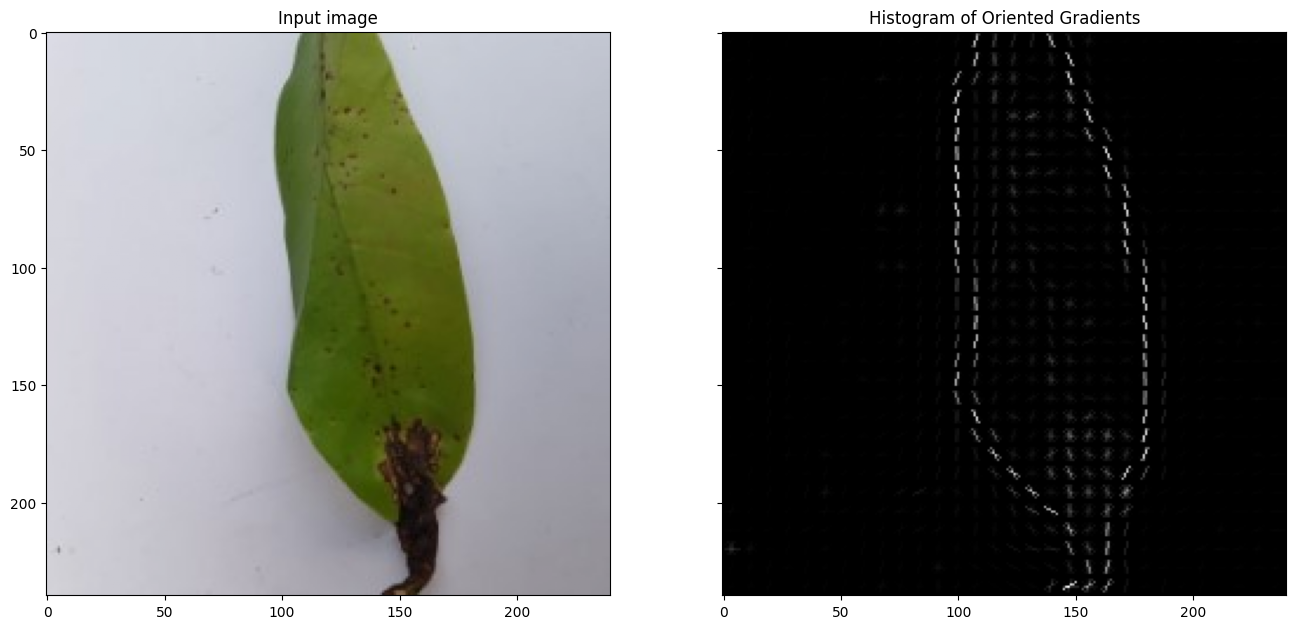

In [8]:
# VISUALIZACIÓN DEL HOG
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(resized_img, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

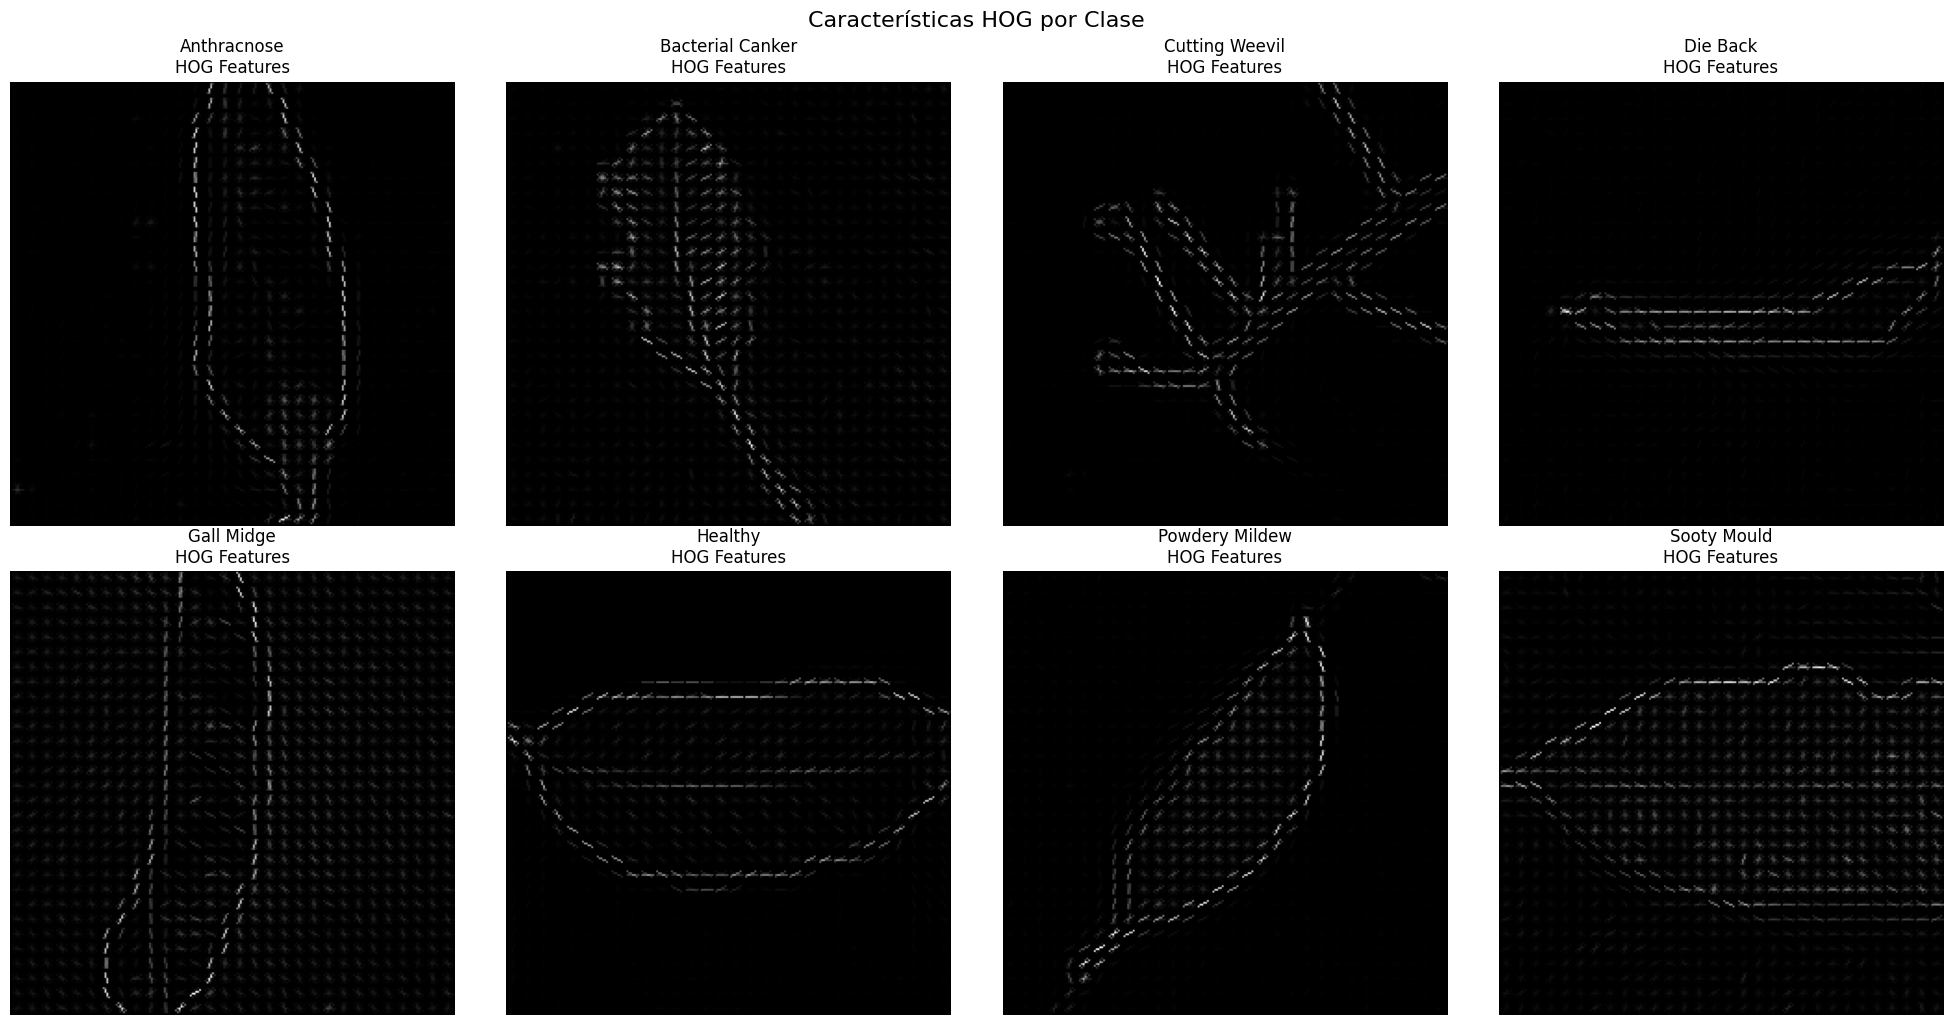

In [9]:
# Vamos a probar HOG con una imagen de cada clase para ver las diferencias
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

hog_features_by_class = {}

for i, class_name in enumerate(classes):
    # Tomar una imagen de cada clase
    class_path = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if images:
        sample_image_path = os.path.join(class_path, images[0])
        img = imread(sample_image_path)
        
        # Redimensionar y extraer HOG
        resized_img = resize(img, (240, 240)) 
        fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                            cells_per_block=(2, 2), visualize=True, channel_axis=-1)
        
        # Guardar características para análisis posterior
        hog_features_by_class[class_name] = fd
        
        # Mostrar imagen HOG
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        axes[i].imshow(hog_image_rescaled, cmap=plt.cm.gray)
        axes[i].set_title(f'{class_name}\nHOG Features')
        axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Características HOG por Clase', y=1.02, fontsize=16)
plt.show()


# PASO 3: CREAR VECTORES HOG PARA TODO EL DATASET

In [10]:
# Listas para almacenar características y etiquetas
X_hog = []  # Características HOG
y_labels = []  # Etiquetas de clase

# Contador para mostrar progreso
total_images = 0
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    total_images += len(images)

print(f"Total de imágenes a procesar: {total_images}")
print(f"Clases a procesar: {len(classes)}")
print()

# Procesar cada clase
processed_images = 0

for class_idx, class_name in enumerate(classes):
    print(f"Procesando clase {class_idx + 1}/{len(classes)}: {class_name}")
    
    class_path = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Procesar cada imagen de la clase
    for img_name in tqdm(images, desc=f"  {class_name}", leave=False):
        try:
            # Cargar imagen
            img_path = os.path.join(class_path, img_name)
            img = imread(img_path)
            
            # Redimensionar imagen (estandarizar a 240x240)
            resized_img = resize(img, (240, 240))
            
            # Extraer características HOG
            hog_features = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                              cells_per_block=(2, 2), visualize=False, channel_axis=-1)
            
            # Agregar a las listas
            X_hog.append(hog_features)
            y_labels.append(class_name)
            
            processed_images += 1
            
        except Exception as e:
            print(f"Error procesando {img_path}: {e}")
            continue

print(f"Imágenes procesadas: {processed_images}")
print(f"Forma de X_hog: {len(X_hog)} x {len(X_hog[0]) if X_hog else 0}")
print(f"Forma de y_labels: {len(y_labels)}")
print(f"Clases únicas: {len(set(y_labels))}")

Total de imágenes a procesar: 4000
Clases a procesar: 8

Procesando clase 1/8: Anthracnose


Procesando clase 2/8: Bacterial Canker


Procesando clase 3/8: Cutting Weevil


Procesando clase 4/8: Die Back


Procesando clase 5/8: Gall Midge


Procesando clase 6/8: Healthy


Procesando clase 7/8: Powdery Mildew


Procesando clase 8/8: Sooty Mould


Imágenes procesadas: 4000
Forma de X_hog: 4000 x 30276
Forma de y_labels: 4000
Clases únicas: 8


## crear dataset de entrenamiento y prueba

In [11]:
# Convertir listas a arrays de NumPy
X_hog_array = np.array(X_hog)
y_labels_array = np.array(y_labels)


# Codificar las etiquetas de texto a números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels_array)

print(f"\n=== CODIFICACIÓN DE ETIQUETAS ===")
print(f"Etiquetas originales: {label_encoder.classes_}")
print(f"Etiquetas codificadas: {y_encoded}")
print(f"Forma de y_encoded: {y_encoded.shape}")

# Crear mapeo de clases
class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(f"Mapeo de clases: {class_mapping}")

# Dividir datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X_hog_array, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n=== DIVISIÓN DE DATOS ===")
print(f"Conjunto de entrenamiento:")
print(f"  - X_train: {X_train.shape}")
print(f"  - y_train: {y_train.shape}")
print(f"Conjunto de prueba:")
print(f"  - X_test: {X_test.shape}")
print(f"  - y_test: {y_test.shape}")



=== CODIFICACIÓN DE ETIQUETAS ===
Etiquetas originales: ['Anthracnose' 'Bacterial Canker' 'Cutting Weevil' 'Die Back' 'Gall Midge'
 'Healthy' 'Powdery Mildew' 'Sooty Mould']
Etiquetas codificadas: [0 0 0 ... 7 7 7]
Forma de y_encoded: (4000,)
Mapeo de clases: {np.str_('Anthracnose'): 0, np.str_('Bacterial Canker'): 1, np.str_('Cutting Weevil'): 2, np.str_('Die Back'): 3, np.str_('Gall Midge'): 4, np.str_('Healthy'): 5, np.str_('Powdery Mildew'): 6, np.str_('Sooty Mould'): 7}

=== DIVISIÓN DE DATOS ===
Conjunto de entrenamiento:
  - X_train: (3200, 30276)
  - y_train: (3200,)
Conjunto de prueba:
  - X_test: (800, 30276)
  - y_test: (800,)


In [12]:
# Verificar distribución de clases en entrenamiento y prueba
print(f"\n=== DISTRIBUCIÓN DE CLASES ===")
print("Entrenamiento:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for label, count in zip(unique_train, counts_train):
    class_name = label_encoder.inverse_transform([label])[0]
    print(f"  {class_name}: {count} imágenes")

print("Prueba:")
unique_test, counts_test = np.unique(y_test, return_counts=True)
for label, count in zip(unique_test, counts_test):
    class_name = label_encoder.inverse_transform([label])[0]
    print(f"  {class_name}: {count} imágenes")


=== DISTRIBUCIÓN DE CLASES ===
Entrenamiento:
  Anthracnose: 400 imágenes
  Bacterial Canker: 400 imágenes
  Cutting Weevil: 400 imágenes
  Die Back: 400 imágenes
  Gall Midge: 400 imágenes
  Healthy: 400 imágenes
  Powdery Mildew: 400 imágenes
  Sooty Mould: 400 imágenes
Prueba:
  Anthracnose: 100 imágenes
  Bacterial Canker: 100 imágenes
  Cutting Weevil: 100 imágenes
  Die Back: 100 imágenes
  Gall Midge: 100 imágenes
  Healthy: 100 imágenes
  Powdery Mildew: 100 imágenes
  Sooty Mould: 100 imágenes


# PASO 4:  Entrenar modelo de clasificiacion

In [13]:
#COMPETENCIA DE MODELOS 

models = {
    'SVM': SVC(kernel='rbf', random_state=42, probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

results = {}

print("=== ENTRENANDO MODELOS ===")
for name, model in models.items():
    print(f"\nEntrenando {name}...")
    
    # Entrenar modelo
    model.fit(X_train, y_train)
    
    # Hacer predicciones
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    # Guardar resultados
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'predictions': y_pred
    }
    
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - F1-Score (macro): {f1_macro:.4f}")
    print(f"  - F1-Score (weighted): {f1_weighted:.4f}")


=== ENTRENANDO MODELOS ===

Entrenando SVM...
  - Accuracy: 0.7963
  - F1-Score (macro): 0.7916
  - F1-Score (weighted): 0.7916

Entrenando Random Forest...
  - Accuracy: 0.7050
  - F1-Score (macro): 0.6924
  - F1-Score (weighted): 0.6924

Entrenando Neural Network...
  - Accuracy: 0.7875
  - F1-Score (macro): 0.7814
  - F1-Score (weighted): 0.7814


In [14]:
for name, result in results.items():
    print(f"{name:<15} {result['accuracy']:<10.4f} {result['f1_macro']:<10.4f} {result['f1_weighted']:<12.4f}")

print(f"\n=== RESUMEN DE RESULTADOS ===")
print(f"{'Modelo':<15} {'Accuracy':<10} {'F1-Macro':<10} {'F1-Weighted':<12}")
print("-" * 80)
# Encontrar el mejor modelo
best_model_name = max(results.keys(), key=lambda x: results[x]['f1_macro'])
print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   F1-Score (macro): {results[best_model_name]['f1_macro']:.4f}")
print(f"   Accuracy: {results[best_model_name]['accuracy']:.4f}")

SVM             0.7963     0.7916     0.7916      
Random Forest   0.7050     0.6924     0.6924      
Neural Network  0.7875     0.7814     0.7814      

=== RESUMEN DE RESULTADOS ===
Modelo          Accuracy   F1-Macro   F1-Weighted 
--------------------------------------------------------------------------------

🏆 MEJOR MODELO: SVM
   F1-Score (macro): 0.7916
   Accuracy: 0.7963


🏆 Modelo ganador: SVM
📊 F1-Score (macro): 0.7916
📊 Accuracy: 0.7963

=== REPORTE DE CLASIFICACIÓN DETALLADO ===
                  precision    recall  f1-score   support

     Anthracnose       0.72      0.76      0.74       100
Bacterial Canker       0.78      0.95      0.86       100
  Cutting Weevil       0.95      0.97      0.96       100
        Die Back       0.93      0.93      0.93       100
      Gall Midge       0.68      0.77      0.72       100
         Healthy       0.75      0.80      0.77       100
  Powdery Mildew       0.85      0.70      0.77       100
     Sooty Mould       0.72      0.49      0.58       100

        accuracy                           0.80       800
       macro avg       0.80      0.80      0.79       800
    weighted avg       0.80      0.80      0.79       800

=== MATRIZ DE CONFUSIÓN ===


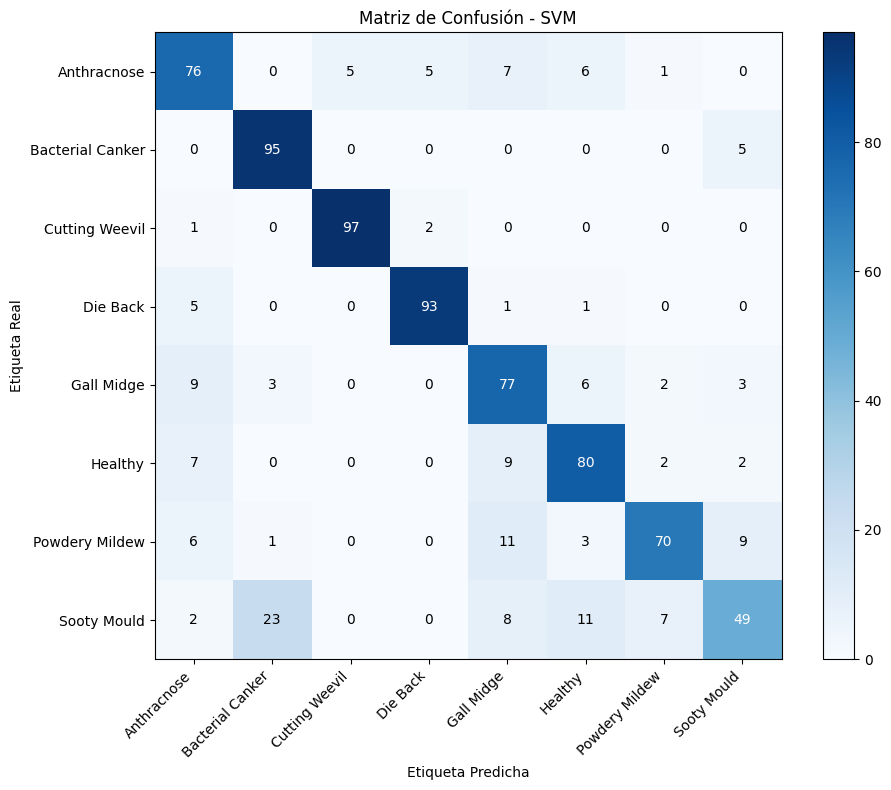

In [15]:
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"🏆 Modelo ganador: {best_model_name}")
print(f"📊 F1-Score (macro): {results[best_model_name]['f1_macro']:.4f}")
print(f"📊 Accuracy: {results[best_model_name]['accuracy']:.4f}")
print()

# Reporte de clasificación detallado
print("=== REPORTE DE CLASIFICACIÓN DETALLADO ===")
class_names = label_encoder.classes_
classification_rep = classification_report(y_test, best_predictions, target_names=class_names)
print(classification_rep)

# Matriz de confusión
print("=== MATRIZ DE CONFUSIÓN ===")
cm = confusion_matrix(y_test, best_predictions)

# Crear visualización de la matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Matriz de Confusión - {best_model_name}')
plt.colorbar()

# Agregar etiquetas
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)

# Agregar valores en cada celda
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()
